In [1]:
import time
import numpy as np

# Audio utils

In [2]:
from abc import abstractmethod

In [3]:
class FeatureModule(object):
    
    def __init__(self, sample_rate, hop_length, num_channels=1, decibels=True):
        self.sample_rate = sample_rate
        self.hop_length = hop_length
        self.num_channels = num_channels
        self.decibels = decibels
        
    def get_expected_frames(self, audio):
         # Simply the number of hops plus one
        num_frames = 1 + len(audio) // self.hop_length
        return num_frames
    
    def get_sample_range(self, num_frames):
         # Calculate the boundaries
        max_samples = num_frames * self.hop_length - 1
        min_samples = max(1, max_samples - self.hop_length + 1)

        # Construct an array ranging between the minimum and maximum number of samples
        sample_range = np.arange(min_samples, max_samples + 1)
        return sample_range
    
    @abstractmethod
    def process_audio(self, audio):
        return NotImplementedError
    
    def to_decibels(self, feats):
        feats = librosa.core.amplitude_to_db(feats, ref=np.max)
        return feats

    def post_proc(self, feats):
        if self.decibels:
            # Convert to decibels (dB)
            feats = self.to_decibels(feats)

            # TODO - make additional variable for 0/1 scaling
            # Assuming range of -80 to 0 dB, scale between 0 and 1
            feats = feats / 80
            feats = feats + 1
        else:
            # TODO - should anything be done here? - would I ever not want decibels?
            pass

        # Add a channel dimension
        feats = np.expand_dims(feats, axis=0)
        return feats
    
    def get_times(self, audio):
        num_frames = self.get_expected_frames(audio)

        frame_idcs = np.arange(num_frames + 1)
        # Obtain the time of the first sample of each frame
        times = librosa.frames_to_time(frames=frame_idcs,
                                       sr=self.sample_rate,
                                       hop_length=self.hop_length)
        return times
    
    def get_sample_rate(self):
        sample_rate = self.sample_rate
        return sample_rate

    def get_hop_length(self):
        hop_length = self.hop_length
        return hop_length

    def get_num_channels(self):
        num_channels = self.num_channels
        return num_channels

    @classmethod
    def features_name(cls):
         return cls.__name__

## patch madmom import error with sed

In [4]:
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.spectrogram import (
    FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor,
    SpectrogramDifferenceProcessor)
from madmom.processors import ParallelProcessor, SequentialProcessor

In [5]:
class LOG_SPECT(FeatureModule):
    def __init__(self, num_channels=1, sample_rate=22050, win_length=2048, hop_size=512, n_bands=[12], mode='online'):
        sig = SignalProcessor(num_channels=num_channels, win_length=win_length, sample_rate=sample_rate)
        self.sample_rate = sample_rate
        self.hop_length = hop_size
        self.num_channels = num_channels
        multi = ParallelProcessor([])
        frame_sizes = [win_length]  
        num_bands = n_bands  
        for frame_size, num_bands in zip(frame_sizes, num_bands):
            if mode == 'online' or mode == 'offline':
                frames = FramedSignalProcessor(frame_size=frame_size, hop_size=hop_size) 
            else:   # for real-time and streaming modes 
                frames = FramedSignalProcessor(frame_size=frame_size, hop_size=hop_size, num_frames=4) 
            stft = ShortTimeFourierTransformProcessor()  # caching FFT window
            filt = FilteredSpectrogramProcessor(
                num_bands=num_bands, fmin=30, fmax=17000, norm_filters=True)
            spec = LogarithmicSpectrogramProcessor(mul=1, add=1)
            diff = SpectrogramDifferenceProcessor(
                diff_ratio=0.5, positive_diffs=True, stack_diffs=np.hstack)
            # process each frame size with spec and diff sequentially
            multi.append(SequentialProcessor((frames, stft, filt, spec, diff)))
        # stack the features and processes everything sequentially
        self.pipe = SequentialProcessor((sig, multi, np.hstack))

    def process_audio(self, audio):
        feats = self.pipe(audio)
        return feats.T

# Beatmap utils

In [6]:
import re
import os
import torch
import math
import scipy.io.wavfile as wav
import subprocess

In [7]:
class Beatmap():    
    
    def __init__(self, beatmap_dir, beatmap, proc, sample_rate=22050, tmp='./wav/', 
                 peak_type='gaussian', hop_size=512, width=4, single_beat_channel=False):
        self.beatmap = beatmap
        self.beatmap_dir = beatmap_dir
        self.sample_rate = sample_rate
        self.proc = proc
        self.tmp = tmp
        self.wavf = None
        self.audiof = None
        self.rate = int(sample_rate / hop_size)
        self.w = width
        self.single_beat_channel = single_beat_channel
    
        self.timestamp = []
        self.beat_len = []
        self.BeatDivisor = None
        self.frames = None # [data]
        self.beats = None # [gt]
        self.downs = None
        self.m = None # [metadata]
        
        peaks = {
            'gaussian': self.create_gaussian_peak, 
            'linear': self.create_linear_peak, 
            'parabolic': self.create_parabolic_peak
        }
        self.create_peak = peaks[peak_type]
        
    def parse_audiof(self):
        f = open(os.path.join(self.beatmap_dir, self.beatmap))
        for l in f:
            if re.match(r'AudioFilename.*', l):
                self.audiof = re.search('AudioFilename:\s*(.*)', l).group(1)
        f.close()
        
        if not os.path.exists(self.audiof):
            for f in os.listdir(self.beatmap_dir):
                if re.match(self.audiof, f, flags=re.IGNORECASE):
                    self.audiof = f
        
    def get_audiof(self):
        if self.audiof == None:
            self.parse_audiof()
        return self.audiof
        
    def parse_ids(self):
        f = open(os.path.join(self.beatmap_dir, self.beatmap))
        for l in f:
            if re.match(r'BeatmapID.*',  l):
                self.BeatmapID = re.search('BeatmapID:\s*(\d+).*', l).group(1)
            if re.match(r'BeatmapSetID.*', l):
                self.eatmapSetID = re.search('BeatmapSetID:\s*(\d+).*', l).group(1)
        if 'BeatmapSetID' not in locals():
            self.BeatmapSetID = self.beatmap_dir.split('/')[-1].split(' ')[0]
        if 'BeatmapID' not in locals():
            self.BeatmapID = self.beatmap_dir.split('/')[-1].split(' ')[0]
        f.close()
            
    def parse_wav(self):
        self.parse_ids();
        self.wavf = str(self.BeatmapSetID) + '-' + str(self.BeatmapID) + '.wav'
        
    def create_wav(self):
        self.parse_wav()
        mp3 = os.path.join(self.beatmap_dir, self.get_audiof())
        wav = os.path.join(self.tmp, self.wavf)
        subprocess.call(['ffmpeg', '-hide_banner', '-loglevel', 'error', '-y', 
                         '-i', mp3, '-ar', str(self.sample_rate), wav])
        
    def get_wav(self):
        if self.wavf == None:
            self.parse_wav()
            if not os.path.exists(os.path.join(self.tmp, self.wavf)):
                self.create_wav()
        return self.wavf
                
    def parse_beatmap(self):
        rate, audio_data = wav.read(os.path.join(self.tmp, self.get_wav()))
        audio_len = np.shape(audio_data)[0]
        f = open(os.path.join(self.beatmap_dir, self.beatmap))
        
        for l in f:
            if re.match(r'BeatDivisor.*', l):
                self.BeatDivisor = re.search('BeatDivisor:\s*(\d+).*', l).group(1)
                self.BeatDivisor = int(self.BeatDivisor)
                break
        for l in f:
            if re.match(r'\[TimingPoints\]', l):
                break
        for l in f:
            if l == "\n":
                break
            a = l.split(',')
            if float(a[1]) < 0:
                continue
            self.beat_len.append(float(a[1]))
            self.timestamp.append(float(a[0])) 
        self.timestamp.append(int(audio_len / rate * 1000))
        f.close()
    
    def process_audio(self):
        feats = self.proc.process_audio(os.path.join(self.beatmap_dir, self.get_audiof()))
        feats = torch.tensor(feats)
        self.frames = torch.transpose(feats, 0, 1)
        
    def create_gaussian_peak(self, y, i):
        alen = len(y)
        w = self.w/2/2
        
        def func(x):
            return math.exp(-j**2/w**2)
        
        j = 0 
        while i+j > 0 and abs(j) <= w*2:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j -= 1
        j = 0
        while i+j < alen and abs(j) <= w*2:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j += 1
            
    def create_parabolic_peak(self, y, i):
        alen = len(y)
        limit = self.w*2
        w = self.w

        def func(x):
            return -(1/w**2 * x**2) + 1

        j = 0        
        while i+j > 0 and abs(j) <= limit:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j -= 1
        j = 0
        while i+j < alen and abs(j) <= limit:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j += 1
            
    def create_linear_peak(self, y, i):
        alen = len(y)
        w = self.w/2
        m = 1/w
        limit = w
        
        def func(x):
            return m*x + 1
        
        j=0
        while i+j > 0 and abs(j) <= limit:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j -= 1
        m = -m
        j = 0
        while i+j < alen and abs(j) <= limit:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j += 1  
    
    def process_beats(self):
        if len(self.timestamp) == 0:
            self.parse_beatmap()
        self.beats = np.zeros(math.ceil(self.timestamp[-1] * 0.001 * self.rate), dtype=np.float32)
        self.downs = np.zeros(math.ceil(self.timestamp[-1] * 0.001 * self.rate), dtype=np.float32)
        
        d = 0
        i = self.timestamp[0] * 0.001 * self.rate
        while i > 0:
            x = round(i)
            self.create_peak(self.beats, x)
            if d % self.BeatDivisor == 0:
                self.create_peak(self.downs, x)
            i -= self.beat_len[0] * 0.001 * self.rate
            d -= 1
        
        for j in range(len(self.timestamp) - 1):
            i = self.timestamp[j] * 0.001 * self.rate
            d = 0
            while i < (self.timestamp[j+1] * 0.001 * self.rate):
                x = round(i)
                self.create_peak(self.beats, x)
                if d % self.BeatDivisor == 0:
                    self.create_peak(self.downs, x)
                i += self.beat_len[j] * 0.001 * self.rate
                d += 1
            if i >= self.timestamp[-1] * 0.001 * self.rate:
                break
                    
    def get_audio(self):
        if self.frames == None:
            self.process_audio()
        return self.frames
    
    def get_beats(self):
        if self.beats == None:
            self.process_beats()
        if self.single_beat_channel == True:
            concat = np.add(self.beats, self.downs)
            concat = np.divide(concat, 2)
            return torch.tensor(concat)
        else:
            return torch.tensor(np.stack((self.beats, self.downs), axis=1))
    
    def get_metadata(self):
        if self.BeatDivisor == None:
            self.parse_beatmap()
        return (self.beatmap, self.rate, self.BeatDivisor)
    
    def get_timings(self):
        if len(self.timestamp) == 0:
            self.parse_beatmap()
        return list(zip(self.timestamp, self.beat_len))

# Dataset

In [8]:
import glob
import copy
import gc
import concurrent.futures
import traceback
import torch
from torch.utils.data import Dataset

In [9]:
class Beatmap_Dataset(Dataset):  
    
    def __init__(self, beatmap_dir, proc, seq_dur=10, sample_rate=22050, hop_size=512, width=4, 
                 peak_type='gaussian', single_beat_channel=False, threads=4, threading=True):
        self.beatmap_dir = beatmap_dir
        self.proc = proc
        self.sample_rate = sample_rate
        self.hop_size = hop_size
        self.beatmaps = []
        self.seq_len = int(seq_dur * sample_rate / hop_size)
        self.width = width
        
        if beatmap_dir == None:
            self.x = []
            self.y = []
            self.m = []
            return
        
        j = 0
        for r, dirs, _ in os.walk(beatmap_dir):
            for dir in dirs:
                for root, _, files in os.walk(os.path.join(r, dir)):
                    for f in files:
                        if re.match('.*.osu$', f):
                            self.beatmaps.append(Beatmap(root, f, proc, sample_rate=sample_rate, 
                                                         hop_size=hop_size, width=width, peak_type=peak_type, single_beat_channel=single_beat_channel))
                            j += 1
                                            
        self.x = [None] * j
        self.y = [None] * j
        self.t = [None] * j
        self.m = [None] * j

        def process(i):
            m = self.beatmaps[i]
            self.beatmaps[i] = None
            try:
                print(str(i) + '/' + str(j-1), m.beatmap)            
                self.x[i] = copy.deepcopy(m.get_audio())
                self.y[i] = copy.deepcopy(m.get_beats())
                self.t[i] = copy.deepcopy(m.get_timings())
                self.m[i] = copy.deepcopy(m.get_metadata())
            except Exception as e:
                traceback.print_exc()
                print("pruning:", m.beatmap)     
                self.x[i] = None
                self.y[i] = None
                self.t[i] = None
                self.m[i] = None
            del m
            gc.collect()

        if threading:
            executor = concurrent.futures.ThreadPoolExecutor(threads)
            list(executor.map(process, range(j)))
        else:
            list(map(process, range(j)))
                        
        self.beatmaps = list(filter(None, self.beatmaps))
        self.x = list(filter(lambda x: x != None, self.x))
        self.y = list(filter(lambda x: x != None, self.y))
        self.t = list(filter(None, self.t))
        self.m = list(filter(None, self.m))
        
    def take(self, ds, i, j):
        self.x = ds.x[i:j]
        self.y = ds.y[i:j]
        self.m = ds.m[i:j]
        self.t = ds.t[i:j]
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        if self.seq_len == 0:
            return self.x[i], self.y[i], self.j[i]
        j = np.random.randint(0, self.y[i].shape[0] - self.seq_len)
        return self.x[i][j: j+self.seq_len], self.y[i][j: j+self.seq_len], self.t[i][0], (self.m[i], i, j)

In [10]:
# debug
log_spect = LOG_SPECT(sample_rate=44100, hop_size=441*2, n_bands=[24], mode='offline')
s = Beatmap_Dataset('../ex/beatmaps', log_spect, sample_rate=44100, hop_size=441*2, width=2, peak_type='linear', threading=True)

0/91/9 TMABird - Everybody's Circulation (Vncegd) [Normal].osu
 TMABird - Everybody's Circulation (Vncegd) [Very Easy].osu
2/9 TMABird - Everybody's Circulation (Vncegd) [Hard (new)].osu
3/9 TMABird - Everybody's Circulation (Vncegd) [Easy (new)].osu
4/9 TMABird - Everybody's Circulation (Vncegd) [Insane].osu
5/9 TMABird - Everybody's Circulation (Vncegd) [Easy].osu
6/9 TMABird - Everybody's Circulation (Vncegd) [Hard].osu
7/9 TMABird - Everybody's Circulation (Vncegd) [Expert].osu
8/9 TMABird - Everybody's Circulation (Vncegd) [Normal (new)].osu
9/9 LamazeP - Spam Jack (OsuToothbrush) [SPAM].osu


# Constants

In [10]:
sample_rate = 44100
hop_size = 441 * 2
seq_dur = 10
peak_type = 'gaussian'
width = 4
single_beat_channel = True

beatmap_dir = '../beatmaps'
ds_path = './datasets/DBN/ds_' + peak_type + '.pkl'
model_path = './models/DBN/model_' + peak_type + '.pt'

# Process Data

In [16]:
start = time.time()

log_spect = LOG_SPECT(sample_rate=sample_rate, hop_size=hop_size, n_bands=[24], mode='offline')
ds = Beatmap_Dataset(beatmap_dir, log_spect, seq_dur=seq_dur, sample_rate=sample_rate, 
                     hop_size=hop_size, peak_type=peak_type, width=width, single_beat_channel=single_beat_channel, threads=64, threading=True)

end = time.time()
print(end - start, 'secs')

0/1511 Chata - Engage (Lasse) [Insane].osu
1/1511 2/1511 sana - kanojo wa tabi ni deru (Firika) [Insane].osu
Mimi - Surrealism (feat. ZAT) (-Tatsuo) [no mania].osu
3/1511 4/1511 StylipS - Prism Sympathy(Asterisk Remix) (iMage--) [Kaleid Liner].osu
Ishida Youko - To the Promised Sky ~The place that I was~ (caren) [Collabo].osu
5/1511 Cranky - Chandelier - King (Mao) [Gero's Insane].osu
6/1511 senya - Akatsuki no Suiheisen ni (Satellite) [Zweib's Insane].osu
7/1511 Tadokoro Azusa - 1HOPE SNIPER (Sotarks) [NiNo's Insane].osu
8/15119/1511 cYsmix - bells! (Gero) [normal!].osu
 fripSide - future gazer (TV Size) (alacat) [Insane].osu10/1511
 Yazawa Nico (CV.Tokui Sora) - Nicopuri Joshidou (yf_bmp) [z1085684963's Insane].osu
11/1511 Hamburgaga - Watame Internet Connection Race (CE6A) [Insane].osu
12/1511 xi - Parousia -LAST JUDGMENT- (Zapy) [Retribution].osu
13/1511 Shiena Nishizawa - Meaning (Taeyang) [xChippy's Insane].osu
14/1511 namirin - Hitokoto no Kyori (sahuang) [Linadeft's Insane].osu

Traceback (most recent call last):
  File "/tmp/ipykernel_20633/3035762184.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_20633/387084890.py", line 202, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_20633/387084890.py", line 177, in process_beats
    if d % self.BeatDivisor == 0:
TypeError: unsupported operand type(s) for %: 'int' and 'NoneType'


pruning: nomico - Bad Apple!! (James) [Normal].osu
99/1511 a_hisa - Cheshire,s dance (Muya) [Normal].osu
100/1511 Roselia - The Everlasting Guilty Crown (Underdogs) [Insane].osu
101/1511 40meter-P - Mousou sketch (Noways) [Insane!].osu
102/1511 sasakure.UK x DECO27 - 39 (Finshie) [Insane].osu
103/1511 Chata - len (Cami) [xiqingwa's Lunatic].osu
104/1511 Fractal Dreamers - Fata Morgana (Natsu) [captin's Insane].osu
105/1511 u's - Snow Halation (Asterisk DnB Remix) (jeydude) [Nico].osu
106/1511 Atoguru - Hana no Sadame (CSAQ) [Insane].osu
107/1511 Daisuke Ishiwatari - Condemnation Wings (Jounzan) [Requiem Aeternam].osu
108/1511 gmtn. (witch's slave) - furioso melodia (Urushi38) [EDITED].osu
109/1511 Warak - Once Upon A Time (Xilver) [UC's Insane].osu
110/1511 Gladenfold - ...To Eternity (LMT) [Yamicchi's Light Insane].osu
111/1511 Krewella - Say Goodbye (Nightcore Mix) (Cut Ver.) (Bquntii) [Ignorance].osu
112/1511 Hatsune Miku - Hand in Hand (Magical Mirai ver.) (Aureola) [Normal].osu
11

Traceback (most recent call last):
  File "/tmp/ipykernel_20633/3035762184.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_20633/387084890.py", line 202, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_20633/387084890.py", line 177, in process_beats
    if d % self.BeatDivisor == 0:
TypeError: unsupported operand type(s) for %: 'int' and 'NoneType'


115/1511 Yoshimura Haruka, Uchida Maaya, Aoki Shiki, Takamori Natsumi, Aihara Kotomi - EVERMORE (M@STER VERSION) (Shunao) [Matha's Insane].osu
116/1511 Hatsuki Yura - Eclipse Parade (Vert) [Zero's Insane].osu
117/1511 Vicetone - Kaleidoscope (Come[Back]Home) [Insane].osu
118/1511 ClariS - Alicia (TV Size) (captin1) [Insane].osu
119/1511 Tanya Degurechaff (CV Yuki Aoi) - Los! Los! Los! (Logic Agent) [Mun's Insane].osu
120/1511 Hatsuki Yura - Kowaku no Mori (mama2093) [Dance].osu
121/1511 Tama - Sonna Yume wo Mita no ~lonely dreaming girl~ (Remix) (BlackSheep) [It's a Snowy Dream [AR9]].osu
122/1511 Sawai Miku - Colorful. (Asterisk DnB Remix) (Asfand) [Vibrant].osu
123/1511 Yunomi & nicamoq - Indoor Kei Nara Trackmaker (dipperbee) [TrAcK MaKeR].osu
124/1511 GTA feat. Sam Bruno - Red Lips (Mendus Remix) (Euny) [Natsu's Insane].osu
125/1511 TrySail - Utsuroi (Short Ver.) (Log Off Now) [Nexus' Insane].osu
126/1511 ZAQ - Seven Doors (eINess) [wkyik's Insane].osu
127/1511 M2U - Stellar (Ultim

Traceback (most recent call last):
  File "/tmp/ipykernel_20633/3035762184.py", line 39, in process
    self.x[i] = copy.deepcopy(m.get_audio())
  File "/tmp/ipykernel_20633/387084890.py", line 197, in get_audio
    self.process_audio()
  File "/tmp/ipykernel_20633/387084890.py", line 104, in process_audio
    feats = self.proc.process_audio(os.path.join(self.beatmap_dir, self.get_audiof()))
  File "/tmp/ipykernel_20633/680612967.py", line 27, in process_audio
    feats = self.pipe(audio)
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/madmom/processors.py", line 120, in __call__
    return self.process(*args, **kwargs)
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/madmom/processors.py", line 424, in process
    data = _process((processor, data, kwargs))
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/madmom/processors.py", line 289, in _process
    return process_tuple[0](*process_tuple[1:-1], **process_tuple[-1])
  F

178/1511 Dark PHOENiX - Taketori Hishou (KanbeKotori) [Extra].osu
179/1511 Mili - Origin (TV Size) (Ryuusei Aika) [kanor's Insane].osu
180/1511 Hanataba - Night of Knights (v2b) [Normal].osu
181/1511 Sagara Kokoro - Hoshizora no Ima (Star Stream) [Insane].osu
182/1511 Hanatan - Uta ni Katachi wa Nai keredo (Asahina Momoko) [Recollection].osu
183/1511 PinocchioP - SLoWMoTIoN (Short Ver.)feat.Hatsune Miku (lllmtklll) [Insane].osu
184/1511 Yoko Takahashi - Zankoku Na Tenshi No These (TV. Size Version) (moph) [Ambient's Insane].osu
185/1511 Noboru ft. Hatsune Miku - Shiroi Yuki No Princess Wa (Hokichi) [ShiraHoki's Light Insane].osu
186/1511 Chitose Sara - Arcadia (Short ver.) (Riven) [-Tochi's Insane].osu
187/1511 eyemedia - Bloody Purity (tsuka) [Normal].osu
188/1511 Atoguru - Itoshi Kimi wo Mitsuke ni (Pizza Kun) [Insane].osu
189/1511 Hanasaka Yui(CV M.A.O) - Harumachi Clover (Naotoshi) [Light Insane].osu
190/1511 Hatsune Miku - Ephemeral (Wishkey) [Fade Away].osu
191/1511 emon - shake 

KeyboardInterrupt: 

In [ ]:
start = time.time()

torch.save(ds, ds_path)

end = time.time()
print(end - start, 'secs')

In [11]:
ds = torch.load(ds_path)

# Model

In [12]:
import torch

In [13]:
import torch.nn as nn
import torch.nn.functional as nnF

In [14]:
class DBN(nn.Module):
    def __init__(self, dim_in, dim_out, num_cells, num_layers, batch_size, kernel_size=3):
        super(DBN, self).__init__()
        
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.dim_hd = num_cells
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.kernel_size = kernel_size
        self.padding = 2
        
        # convolution
        K = self.kernel_size
        P = 1
        S = 1
        # pooling
        p = 0
        k = 2
        s = 2
        
        # temporal
        W = dim_in[1]
        temporal_dim = int(((W - K + 2*P)/S) + 1)
        #self.temporal_dim = int(((temporal_dim - k + 2*p)/s) + 1)
        self.temporal_dim = temporal_dim
        
        # spectral
        W = dim_in[0]
        spectral_dim = int(((W - K + 2*P)/S) + 1)
        self.spectral_dim = int(((spectral_dim - k + 2*p)/s) + 1)
        self.conv_out = self.temporal_dim
        
        self.conv1 = nn.Conv2d(1, 1, (3, self.kernel_size), padding=1)
        self.lstm1 = nn.LSTM(input_size=self.conv_out,
                           hidden_size=self.dim_hd,
                           num_layers=self.num_layers,
                           batch_first=True,
                           bidirectional=False)
        self.linear0 = nn.Linear(self.dim_hd, self.dim_hd)
        self.linear1 = nn.Linear(self.dim_hd, self.dim_out)
        self.softmax = nn.Softmax(dim=0)
        self.hidden = None
        
    def init_hidden(self, batch_size, device):
        hidden_state = torch.zeros(self.num_layers, batch_size, self.dim_hd).to(device)
        cell_state = torch.zeros(self.num_layers, batch_size, self.dim_hd).to(device)
        self.hidden = (hidden_state, cell_state)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = x.squeeze(1)
        x = nnF.relu(x)
        #x = nnF.max_pool2d(x, (1,2))
        x, self.hidden = self.lstm1(x, self.hidden)
        #x = self.linear0(x)
        x = self.linear1(x)
        #x = self.softmax(x)    
        return x

# Training

In [15]:
import torch
from torch.utils.data import DataLoader
from torchinfo import summary
from qqdm.notebook import qqdm
import matplotlib.pyplot as plt

In [16]:
epochs = 60
batch_size = 32
init_trunc = 1

In [18]:
dim_in = (ds.seq_len, ds.x[0].shape[1])
dim_out = 1 #ds.y[0].shape[1] + 1

In [19]:
epoch_cum = 0
model = DBN(dim_in=dim_in, dim_out=dim_out, num_cells=64, num_layers=8, batch_size=batch_size, kernel_size=5)
summary(model, (1, dim_in[0], dim_in[1]), col_width=16,
        col_names=["input_size",
                "output_size",
                "num_params",
                "kernel_size",
                "mult_adds",])

Layer (type:depth-idx)                   Input Shape      Output Shape     Param #          Kernel Shape     Mult-Adds
DBN                                      --               --               --               --               --
├─Conv2d: 1-1                            [1, 1, 500, 280] [1, 1, 500, 278] 16               [1, 1, 3, 5]     2,224,000
├─LSTM: 1-2                              [1, 500, 278]    [1, 500, 64]     321,024          --               160,512,000
├─Linear: 1-3                            [1, 500, 64]     [1, 500, 1]      65               [64, 1]          65
├─Linear: 1-4                            --               --               (recursive)      [64, 1]          --
├─Softmax: 1-5                           --               --               --               --               --
Total params: 321,105
Trainable params: 321,105
Non-trainable params: 0
Total mult-adds (M): 162.74
Input size (MB): 0.56
Forward/backward pass size (MB): 1.37
Params size (MB): 1.28
Estimated 

In [21]:
train_ds = Beatmap_Dataset(None, None, seq_dur=seq_dur, sample_rate=sample_rate, 
                     hop_size=hop_size, peak_type=peak_type, width=width, single_beat_channel=single_beat_channel)
val_ds = Beatmap_Dataset(None, None, seq_dur=seq_dur, sample_rate=sample_rate, 
                     hop_size=hop_size, peak_type=peak_type, width=width, single_beat_channel=single_beat_channel)

train_ds.take(ds, 0, int(len(ds) * 0.8))
val_ds.take(ds, int(len(ds) * 0.8), len(ds))

train_ldr = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_ldr = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [22]:
device = torch.device('cuda')
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [42]:
def train():
    global epoch_cum
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        info = qqdm(train_ldr)
        for x, y, t, m, in info:
            model.init_hidden(x.shape[0], device)
            X, Y = x.to(device), y.to(device)

            optimizer.zero_grad()
            O = model(X)

            for i in range(Y.shape[0]):
                l = int(t[1][i] * 0.001 * m[0][1][i] * init_trunc)
                O[i][0:l] = torch.tensor([[0] * (dim_out)] * l)        
                Y[i][0:l] = torch.tensor([0 * (dim_out)] * l)

            loss = criterion(O[:,:,0:(dim_out)], Y.unsqueeze(1))
            loss.backward()
            optimizer.step()

            #print(loss.item())        
            train_loss += loss.item()
            info.set_infos({'loss': f'{loss.item():.4f}'})

        model.eval()
        torch.no_grad()
        val_loss = 0
        #info = qqdm(val_ldr)
        #for x, y, t, m in info:
        for x, y, t, m in val_ldr:
            model.init_hidden(x.shape[0], device)
            X, Y = x.to(device), y.to(device)

            O = model(X)

            for i in range(O.shape[0]):
                l = int(t[1][i] * 0.001 * m[0][1][i] * init_trunc)
                O[i][0:l] = torch.tensor([[0] * (dim_out)] * l)
                Y[i][0:l] = torch.tensor([0 * (dim_out)] * l)

            loss = criterion(O[:,:,0:(dim_out)], Y.unsqueeze(1))

            #print(loss.item())
            val_loss += loss.item()

        train_loss = train_loss/len(train_ldr)    
        val_loss = val_loss/len(val_ldr)
        print(epoch+epoch_cum, 'of', epochs+epoch_cum)
        print("TRAIN LOSS:", train_loss)
        print("VAL LOSS:", val_loss)
        
        for i in range(dim_out):
            plt.plot(O[0,:,i].cpu().detach().numpy())
            plt.plot(y[i])
            plt.show()
            
    epoch_cum += epochs

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:04<00:00:00  7.59it/s  0.0624                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([28, 1, 500])) that is different to the input size (torch.Size([28, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 of 60
TRAIN LOSS: 0.05990751862928674
VAL LOSS: 0.06148778609931469


/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([7, 1, 500])) that is different to the input size (torch.Size([7, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


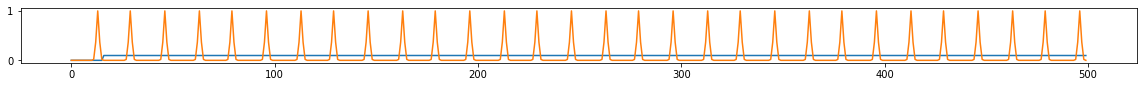

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:04<00:00:00  8.06it/s  0.0538                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1, 500])) that is different to the input size (torch.Size([32, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([28, 1, 500])) that is different to the input size (torch.Size([28, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1 of 60
TRAIN LOSS: 0.059691761997905934
VAL LOSS: 0.06106954663991928


/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([7, 1, 500])) that is different to the input size (torch.Size([7, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


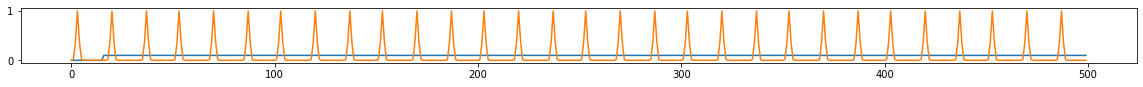

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:04<00:00:00  8.19it/s  0.0623                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1, 500])) that is different to the input size (torch.Size([32, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([28, 1, 500])) that is different to the input size (torch.Size([28, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2 of 60
TRAIN LOSS: 0.05973233171814197
VAL LOSS: 0.061112237721681596


/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([7, 1, 500])) that is different to the input size (torch.Size([7, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


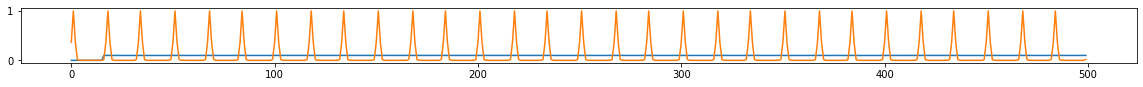

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:04<00:00:00  8.14it/s  0.0610                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1, 500])) that is different to the input size (torch.Size([32, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([28, 1, 500])) that is different to the input size (torch.Size([28, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


3 of 60
TRAIN LOSS: 0.05978010343136014
VAL LOSS: 0.06096649505198002


/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([7, 1, 500])) that is different to the input size (torch.Size([7, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


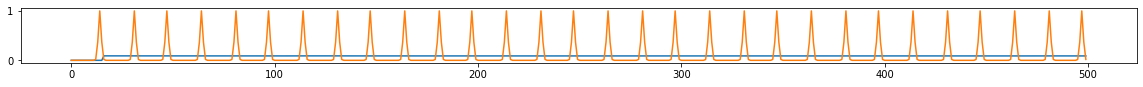

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:04<00:00:00  8.11it/s  0.0582                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1, 500])) that is different to the input size (torch.Size([32, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([28, 1, 500])) that is different to the input size (torch.Size([28, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


4 of 60
TRAIN LOSS: 0.059678624812010174
VAL LOSS: 0.061131437122821805


/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([7, 1, 500])) that is different to the input size (torch.Size([7, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


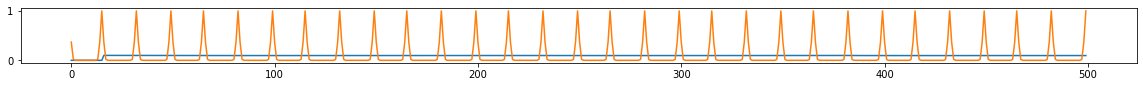

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:04<00:00:00  7.82it/s  0.0560                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1, 500])) that is different to the input size (torch.Size([32, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([28, 1, 500])) that is different to the input size (torch.Size([28, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


5 of 60
TRAIN LOSS: 0.059744658401689014
VAL LOSS: 0.06109200045466423


/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([7, 1, 500])) that is different to the input size (torch.Size([7, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


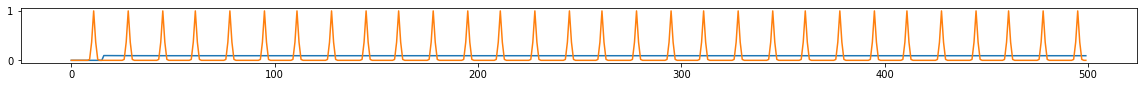

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:04<00:00:00  8.06it/s  0.0587                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1, 500])) that is different to the input size (torch.Size([32, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([28, 1, 500])) that is different to the input size (torch.Size([28, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


6 of 60
TRAIN LOSS: 0.05969701797978298
VAL LOSS: 0.06129000186920166


/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([7, 1, 500])) that is different to the input size (torch.Size([7, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


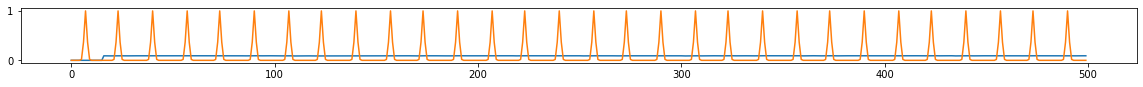

 Iters    Elapsed Time      Speed     loss                                      
 12/37  00:00:01<00:00:03  7.79it/s  0.0617                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1, 500])) that is different to the input size (torch.Size([32, 500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

In [43]:
plt.rcParams["figure.figsize"] = (20,1)
start = time.time()

train()

end = time.time()
print(end - start, 'secs')

In [ ]:
plt.rcParams["figure.figsize"] = (20,1)
start = time.time()

train()

end = time.time()
print(end - start, 'secs')

In [ ]:
torch.save(model.state_dict(), model_path)

Traceback (most recent call last):
  File "/tmp/ipykernel_20633/3035762184.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_20633/387084890.py", line 202, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_20633/387084890.py", line 187, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_20633/387084890.py", line 118, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 15863 is out of bounds for axis 0 with size 15850


pruning: Hatsuki Yura - Kowaku no Mori (mama2093) [Dance].osu


Traceback (most recent call last):
  File "/tmp/ipykernel_20633/3035762184.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_20633/387084890.py", line 202, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_20633/387084890.py", line 176, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_20633/387084890.py", line 118, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 12646 is out of bounds for axis 0 with size 12646


pruning: Hatsune Miku - World is Mine (tom800510) [Queen!!].osu


Traceback (most recent call last):
  File "/tmp/ipykernel_20633/3035762184.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_20633/387084890.py", line 202, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_20633/387084890.py", line 176, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_20633/387084890.py", line 118, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 9546 is out of bounds for axis 0 with size 9546


pruning: Hanataba - Night of Knights (v2b) [Normal].osu


Traceback (most recent call last):
  File "/tmp/ipykernel_20633/3035762184.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_20633/387084890.py", line 202, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_20633/387084890.py", line 187, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_20633/387084890.py", line 118, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 7829 is out of bounds for axis 0 with size 7829


pruning: Warak - REANIMATE (iyasine) [xsrs's Extra].osu


In [23]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>